# Assignment 3
## Adult income dataset

# Summary

In this notebook I tested four different classifiers to predict where income of a person will place in high (>50k)or under this limit.  There were 14 attributes in this dataset including numerical and categorical datat type. 

**Data Preparation**

Also the following process were conducted to prepare data before both training and testing:

* Removing any unmeaningful feature (e.g Id) before training
* Filling NA values with median and mode of feature, for numerical and categorical features respectively.
* Scaling using robust scaler (because of having outliers, also normalization was avoided because of unnormalized distribution of data) 
* To make categorical datatype usable, they were encoded to numerical values. 
* For Feature engineering, IQR Score methods was tried to remove outliers was not a successful as it removed most of samples. Also "education-num" and "education" seemed to represent the same information, therefore I tried removing one of them (education-num) which led led to lower F-1 score, therefore undid that. In another unsuccessful try to improve features by dimention reduction I merged capital-gain and capital loss into a new feature called capital-change, however it reduced the F-1 slightly.

**EAD**

EAD in the tabular and plots (pair plot) was done to bether notice the distribution of each feature and correelations between features and labels. As a result of observations on the pair plots, it was noticed that some features had more correlation ( formed oval shape)  while some seemed uncorrelated (data forming a horizontal or vertical lines). Also looking at the tabular data description it was noticed that some values are probably outliers (e.g. working 99 hr per week) and also standard deviation of some features were so large (e.g. capital-gain and capital-loss) which could mean more outlier datapoints within them. 

**Training**

Finally the following models were trained and optimum values of their hyper prameters were found using Grid Search method:

* Decision Tree (Best Kaggle F-1 = 85.25 % Best Local F-1 = 67.13 %)
* Ada Boost (Best Kaggle F-1 = 85.87 % Best Local F-1 = 69.72 %)
* Gradient Boost (Best Kaggle F-1 = 85.46 % Best Local F-1 = 69.39 %)
* Random Forest (Best Kaggle F-1 = 85.39 % Best Local F-1 = 67.12 %)

**Model Selection**
As kaggle F-1 score validated the prioprity of tried models, **Ada Boost** was selected as the most accurate model in this notebook.

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder #Encoding
from sklearn.ensemble import GradientBoostingClassifier # Classifier
from sklearn.ensemble import AdaBoostClassifier # Classifier
from sklearn.ensemble import RandomForestClassifier # Classifier
from sklearn.model_selection import GridSearchCV #Optimization
from pandas.api.types import is_string_dtype #Checking type
from pandas.api.types import is_numeric_dtype #Checking type
from sklearn.metrics import f1_score #Scoring
from sklearn.preprocessing import RobustScaler #Scaling
from sklearn.preprocessing import StandardScaler #Scaling
from sklearn.model_selection import cross_val_score #Cross validation training 
from sklearn.preprocessing import Normalizer #Normalization
import seaborn as sns #Pairplot diagrams
import matplotlib.pyplot  as plt #showing charts
%matplotlib inline

# Loading CSV data Into a Dataframe

In [2]:
df_trainX = pd.read_csv("./uri-ml-hw-3-f21/xTrain.csv" )# Loading input-train dataset

df_trainY = pd.read_csv("./uri-ml-hw-3-f21/yTrain.csv" )#Loading lavel-train dataset

# EAD and Train Data Preparation

In [3]:
df_trainX.head()#reperesentation of raw input-dataset

Id  age         workclass  fnlwgt     education  education-num  \
0   0   51      Self-emp-inc  200046     Bachelors             13   
1   2   35           Private   61518       HS-grad              9   
2   3   31  Self-emp-not-inc  134615  Some-college             10   
3   4   36           Private  326352       Masters             14   
4   5   34  Self-emp-not-inc   80933       HS-grad              9   

       marital-status       occupation   relationship   race   sex  \
0           Separated            Sales      Unmarried  White  Male   
1  Married-civ-spouse  Exec-managerial        Husband  White  Male   
2  Married-civ-spouse   Prof-specialty        Husband  White  Male   
3       Never-married   Prof-specialty  Not-in-family  White  Male   
4            Divorced  Farming-fishing  Not-in-family  White  Male   

   capital-gain  capital-loss  hours-per-week native-country  
0             0          2824              40  United-States  
1             0             0              35  United-States  
2             0             0              50  United-States  
3             0             0              45  United-States  
4             0             0              40  United-States

id column is not informative, so it is better to drop it to prevent misleading model
Also education-num is the same info as "education" is it is a repetitive data which leads to overfitting. we drop it

In [4]:
df_trainX.drop(columns=["Id"], inplace= True)

In [5]:
df_trainY.head()#reperesentation of raw output-dataset

Id  Predicted
0   0          1
1   2          0
2   3          1
3   4          0
4   5          0

In [6]:
df_trainX.isnull().values.any()# CHECK IF THERE IS nan values in xtrain

True

There are Nan values in the input dataset, so we will fill in the next section.
The other option could be dropping those rows/columns containing Nan, but it will lead to loosing some precious info. Therefore it was decided to fill numerical columns with mean, and categorical columns with mode of their specific columns.

In [7]:
df_trainY.isnull().values.any()# CHECK IF THERE IS nan values in ytrain

False

## Filling NA cells 

In [8]:
#Filling any Nan cel with mean/mode values
for col in df_trainX.columns:#check
    
    if (is_numeric_dtype(df_trainX[col])):#check
    
        mean_value=df_trainX[col].mean(skipna=True)#check
    
        df_trainX[col].fillna(value=mean_value, inplace=True)# Replace NaNs in column  with the mean of values in the same column
        
    elif (is_string_dtype(df_trainX[col])):#check
        
        mode_value=df_trainX[col].value_counts().idxmax()
    
        df_trainX[col].fillna(value=mode_value, inplace=True)

df_trainX.isnull().values.any()#Verify there is no Nan value

False

## Encoding

We only need to encode categorical columns, therefore we devide the original input dataframe of train, to a df with categorical and another df with numerical values

In [9]:
# Categorical dataframe
categ_df = pd.DataFrame()#Makijng an empty dataframe for categorical columns

for col in df_trainX.columns:
    
    if (is_string_dtype(df_trainX[col])):
        
        categ_df[col] = df_trainX[col]
        
        df_trainX.drop([col], axis=1 , inplace= True)#Dropping the categorical col from original df
        
# Numerical dataframe        
num_df = df_trainX


categ_df.head()#Categorical df representation before encoding

workclass     education      marital-status       occupation  \
0      Self-emp-inc     Bachelors           Separated            Sales   
1           Private       HS-grad  Married-civ-spouse  Exec-managerial   
2  Self-emp-not-inc  Some-college  Married-civ-spouse   Prof-specialty   
3           Private       Masters       Never-married   Prof-specialty   
4  Self-emp-not-inc       HS-grad            Divorced  Farming-fishing   

    relationship   race   sex native-country  
0      Unmarried  White  Male  United-States  
1        Husband  White  Male  United-States  
2        Husband  White  Male  United-States  
3  Not-in-family  White  Male  United-States  
4  Not-in-family  White  Male  United-States

In [10]:
num_df.head()#Numerical df representation

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0   51  200046             13             0          2824              40
1   35   61518              9             0             0              35
2   31  134615             10             0             0              50
3   36  326352             14             0             0              45
4   34   80933              9             0             0              40

In [11]:
enc = OrdinalEncoder() # Initialization of encoder object 
#unique values per feature and transform the data to an ordinal encoding

enc.fit(categ_df.values[:,:])#Fit the OrdinalEncoder object to categ_df

categ_array_encoded = enc.transform(categ_df.values[:,:])#Transform categ_df to ordinal codes.

The output will be type array as shown below. But we need it to be switched back to a data frame

In [12]:
type(categ_array_encoded)

numpy.ndarray

In [13]:
#convert categ_array_encoded np array to df
catg_df_encoded = pd.DataFrame(data=categ_array_encoded, columns= categ_df.columns)

catg_df_encoded.head()# Representation of catg_df_encoded dataframe

workclass  education  marital-status  occupation  relationship  race  sex  \
0        4.0        9.0             5.0        11.0           4.0   4.0  1.0   
1        3.0       11.0             2.0         3.0           0.0   4.0  1.0   
2        5.0       15.0             2.0         9.0           0.0   4.0  1.0   
3        3.0       12.0             4.0         9.0           1.0   4.0  1.0   
4        5.0       11.0             0.0         4.0           1.0   4.0  1.0   

   native-country  
0            38.0  
1            38.0  
2            38.0  
3            38.0  
4            38.0

Now we need to cancatinate "catg_df_encoded" and "num_df" to a unique dataframe of numbers

## Concatination of numerical and originally categorical values

In [14]:
encoded_df_trainX = pd.concat([num_df,catg_df_encoded ], axis = 1)#Cancatinate two numeric df

encoded_df_trainX.head()#representation of cancatination result

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   51  200046             13             0          2824              40   
1   35   61518              9             0             0              35   
2   31  134615             10             0             0              50   
3   36  326352             14             0             0              45   
4   34   80933              9             0             0              40   

   workclass  education  marital-status  occupation  relationship  race  sex  \
0        4.0        9.0             5.0        11.0           4.0   4.0  1.0   
1        3.0       11.0             2.0         3.0           0.0   4.0  1.0   
2        5.0       15.0             2.0         9.0           0.0   4.0  1.0   
3        3.0       12.0             4.0         9.0           1.0   4.0  1.0   
4        5.0       11.0             0.0         4.0           1.0   4.0  1.0   

   native-country  
0            38.0  
1            38.0  
2            38.0  
3            38.0  
4            38.0

As we can see above, each columns has a different range of number. To achive better model we need to scale them.
As a result of scaling, input data will be more robust to outliers.
The following Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range).The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [15]:
encoded_df_trainX.describe() #Statistical description of input data

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  34190.000000  3.419000e+04   34190.000000  34190.000000  34190.000000   
mean      38.659901  1.890571e+05      10.058906   1077.882890     85.868295   
std       13.930695  1.050410e+05       2.575800   7476.866995    399.503348   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       27.000000  1.173675e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.777330e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.366840e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week     workclass     education  marital-status  \
count    34190.000000  34190.000000  34190.000000    34190.000000   
mean        40.171922      3.098157     10.284937        2.635010   
std         12.547108      1.093705      3.891785        1.510019   
min          1.000000      0.000000      0.000000        0.000000   
25%         40.000000      3.000000      9.000000        2.000000   
50%         40.000000      3.000000     11.000000        2.000000   
75%         45.000000      3.000000     12.000000        4.000000   
max         99.000000      7.000000     15.000000        6.000000   

         occupation  relationship          race           sex  native-country  
count  34190.000000  34190.000000  34190.000000  34190.000000    34190.000000  
mean       6.243434      1.459462      3.665165      0.665575       36.443785  
std        3.940128      1.606945      0.849643      0.471796        6.006518  
min        0.000000      0.000000      0.000000      0.000000        0.000000  
25%        3.000000      0.000000      4.000000      0.000000       38.000000  
50%        7.000000      1.000000      4.000000      1.000000       38.000000  
75%        9.000000      3.000000      4.000000      1.000000       38.000000  
max       13.000000      5.000000      4.000000      1.000000       40.000000

mean working hour is 40.17 which makes sense.
Maximum working hour has been 99 hours which is crazy!

## View correlation between features before preprocesing of input data

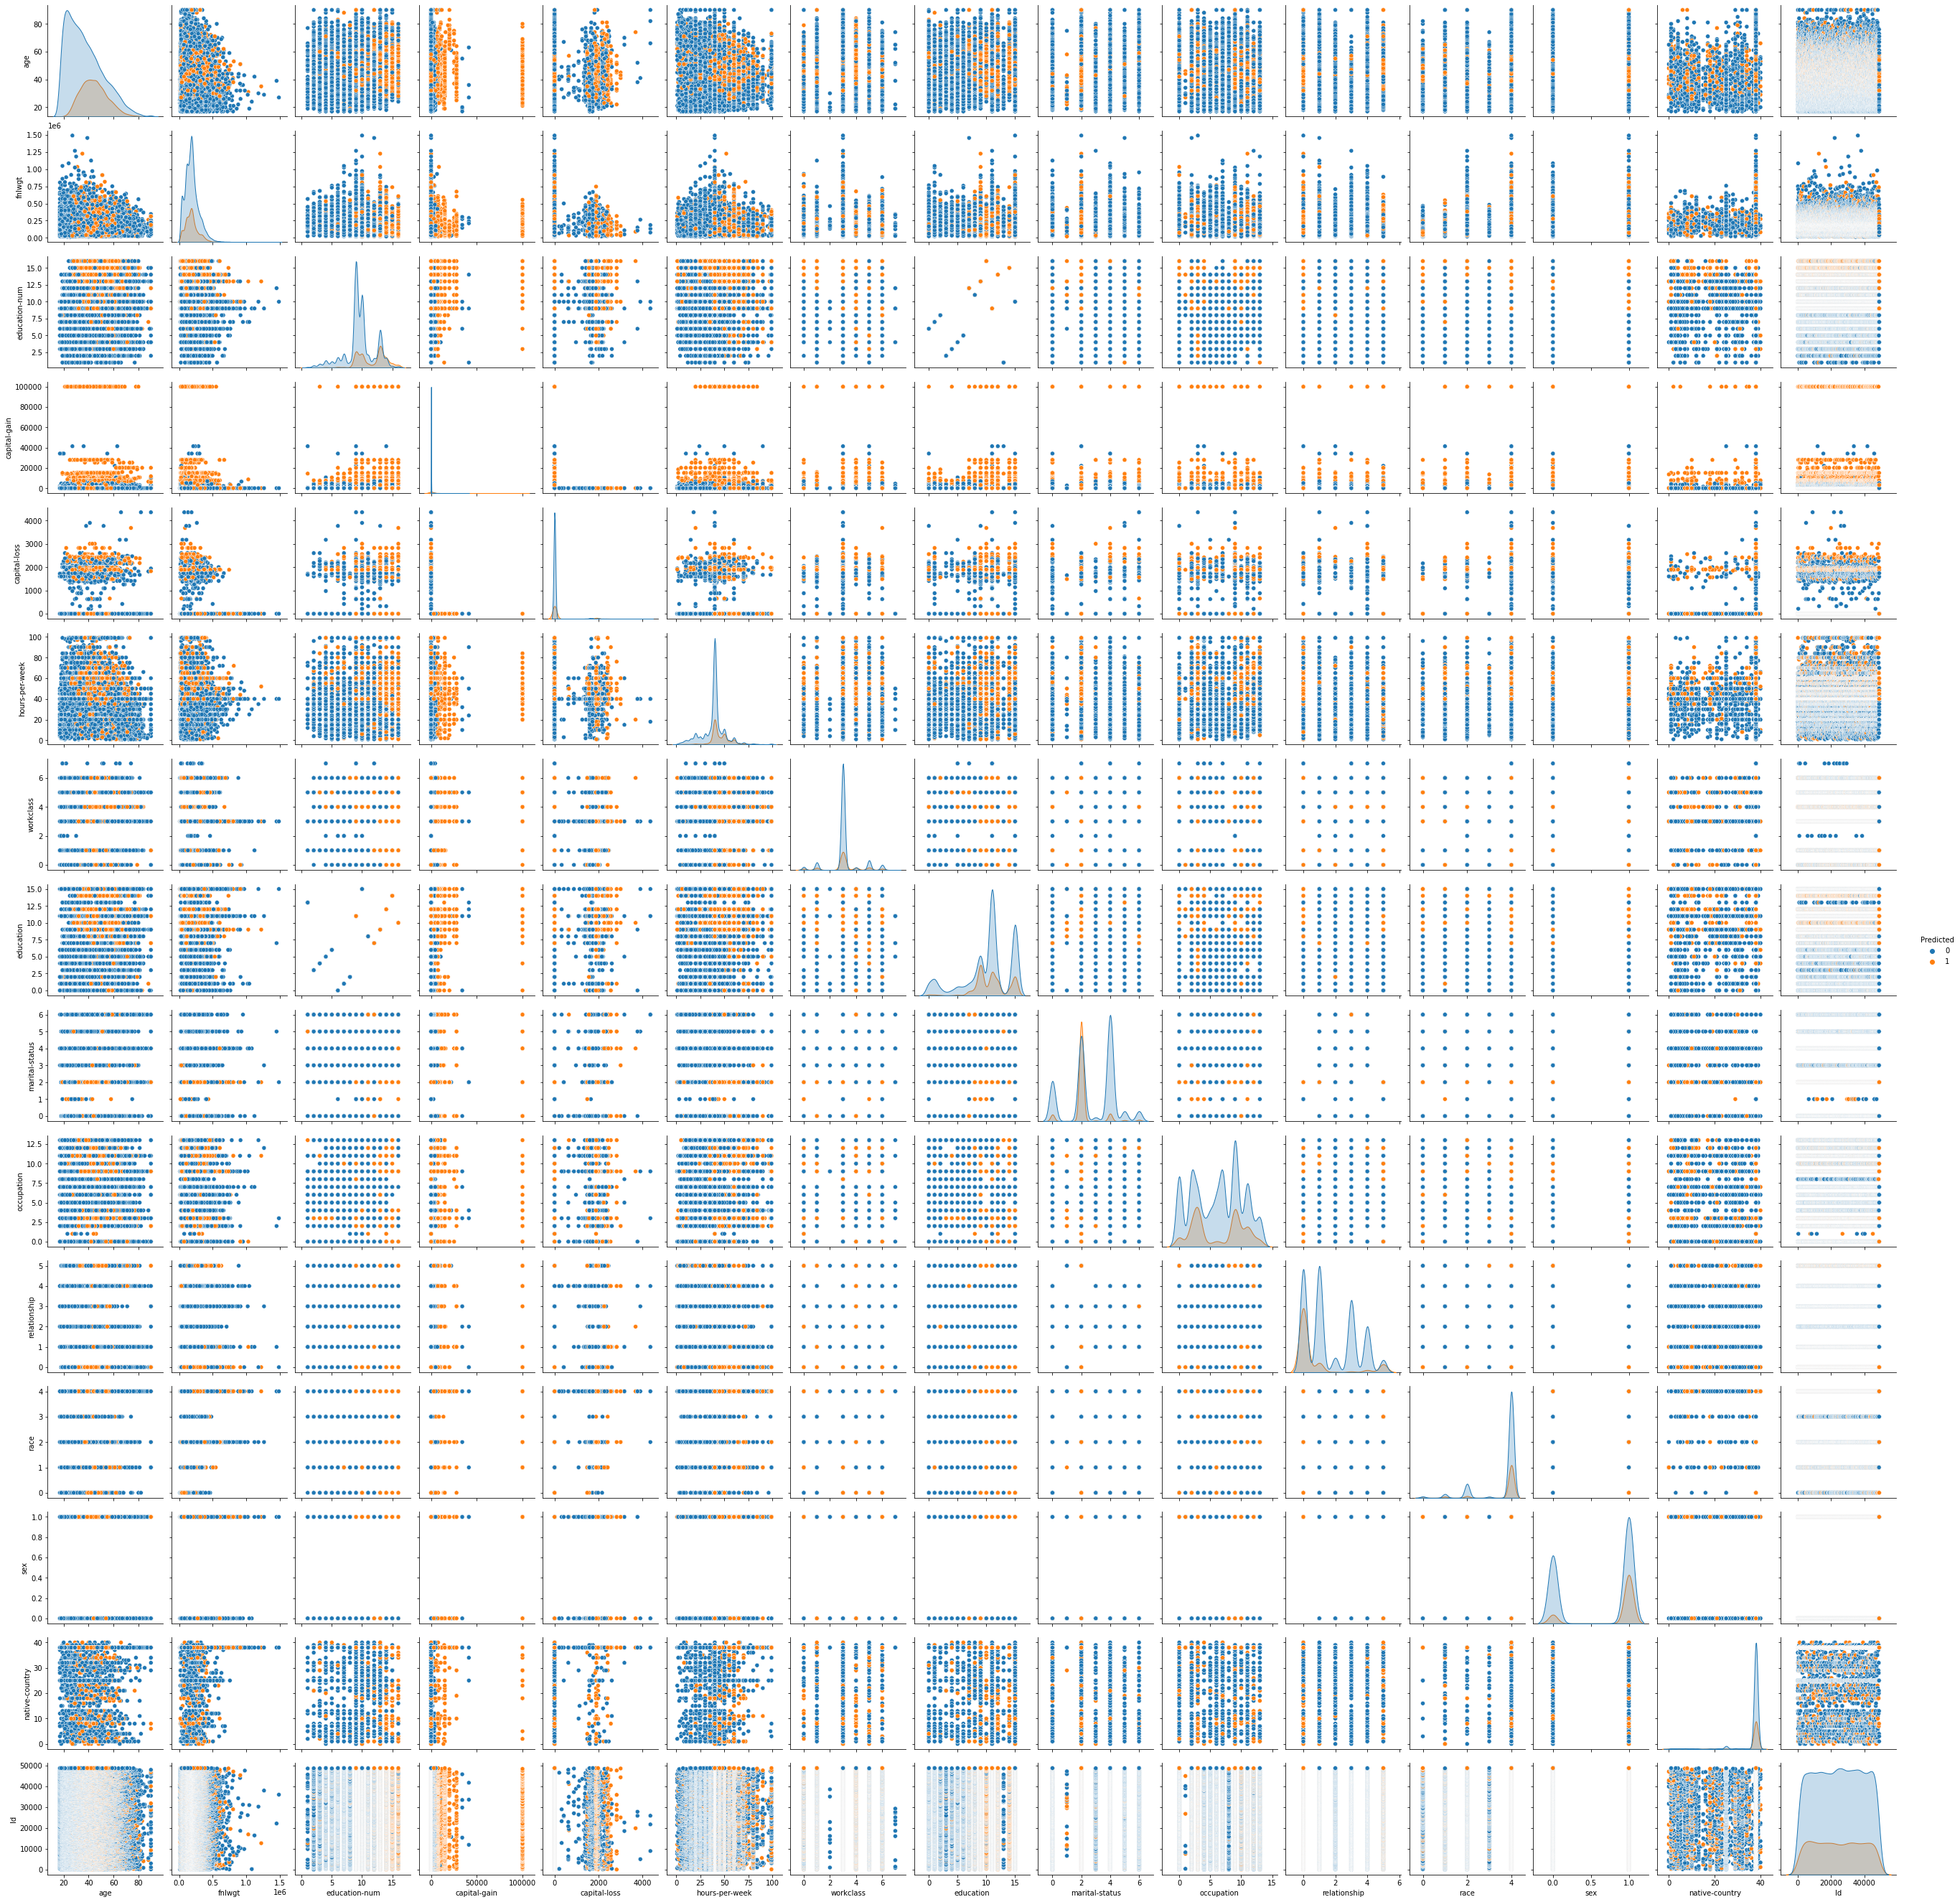

In [16]:
whole_dataset_raw = pd.concat([encoded_df_trainX,df_trainY ], axis = 1)#Cancatinate two numeric df

sns.pairplot(data= whole_dataset_raw, hue="Predicted")

## Feature Engineering

I tried making a new feature called capital-chang, Combining capital-gain with negative values of capital loss ,but it slghty worsened the F-1.
I also tried to remove outliers using IQR Score as below, but all rows were having atleast an outliers, so removing the whole line could not be an option. Maybe using the median could help, which could be tried later.

In [17]:
Q1 = encoded_df_trainX.quantile(0.25)

Q3 = encoded_df_trainX.quantile(0.75) 

IQR = Q3 - Q1

# print(encoded_df_trainX < (Q1 - 1.5 * IQR)) or (encoded_df_trainX > (Q3 + 1.5 * IQR))

encoded_df_trainX_out = encoded_df_trainX[~((encoded_df_trainX < (Q1 - 1.5 * IQR)) | (encoded_df_trainX > (Q3 + 1.5 * IQR))).any(axis=1)]

## Scaling

### RobustScaler

In [18]:
rob_scaler = RobustScaler() #Initilization of scaler object
features = np.array(encoded_df_trainX.columns)
# features =  features[:-1]#Removing labels (last column) from the list of candidate columns for scaling
features = features.reshape(-1 , 1)
# features.shape#Shape of features candidate for scaling

for feature in features:
    
    encoded_df_trainX[feature] = rob_scaler.fit_transform(encoded_df_trainX[feature])
    
rob_scaled_df_trainX = encoded_df_trainX

# rob_scaled_df_trainX.head(20)#Representation of DF after scaling by "RobustScaler"

# Test data preparation

In [19]:
df_testX = pd.read_csv("./uri-ml-hw-3-f21/xTest.csv"  )

df_testX.head()

Id  age         workclass  fnlwgt     education  education-num  \
0  25561   49  Self-emp-not-inc  225456     Bachelors             13   
1  10988   28           Private  134813       HS-grad              9   
2   6549   50           Private  177896     Doctorate             16   
3  30130   26           Private  106950  Some-college             10   
4  38343   52         Local-gov  266138     Assoc-voc             11   

       marital-status       occupation   relationship   race   sex  \
0  Married-civ-spouse            Sales        Husband  White  Male   
1       Never-married   Prof-specialty      Own-child  White  Male   
2  Married-civ-spouse   Prof-specialty        Husband  White  Male   
3       Never-married     Craft-repair  Not-in-family  Black  Male   
4  Married-civ-spouse  Exec-managerial        Husband  White  Male   

   capital-gain  capital-loss  hours-per-week native-country  
0             0             0              60  United-States  
1             0             0              40  United-States  
2             0             0              40  United-States  
3             0             0              40  United-States  
4             0             0              35  United-States

In [20]:
Id_dataframe = pd.DataFrame()

Id_dataframe["Id"] = df_testX["Id"]

df_testX.drop(columns=["Id"], inplace= True)

 We need to prepare data as I did for training dataset. I can later make a function for data preparation to be used for any dataset

## Filling NA data in test dataset

In [21]:
#Filling any Nan cel with mean/mode values
for col in df_testX.columns:#check
    
    if (is_numeric_dtype(df_testX[col])):#check
    
        mean_value=df_testX[col].mean(skipna=True)#check
    
        df_testX[col].fillna(value=mean_value, inplace=True)# Replace NaNs in column  with the mean of values in the same column
        
    elif (is_string_dtype(df_testX[col])):#check
        
        mode_value=df_testX[col].value_counts().idxmax()
    
        df_testX[col].fillna(value=mode_value, inplace=True)

## Encoding of test dataset

In [22]:
# Categorical dataframe
test_categ_df = pd.DataFrame()#Makijng an empty dataframe for categorical columns

for col in df_testX.columns:
    
    if (is_string_dtype(df_testX[col])):
        
        test_categ_df[col] = df_testX[col]
        
        df_testX.drop([col], axis=1 , inplace= True)#Dropping the categorical col from original df
        
        
# Numerical dataframe        
test_num_df = df_testX

In [23]:
test_num_df.head()

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0   49  225456             13             0             0              60
1   28  134813              9             0             0              40
2   50  177896             16             0             0              40
3   26  106950             10             0             0              40
4   52  266138             11             0             0              35

In [24]:
test_enc = OrdinalEncoder() # Initialization of encoder object 
#unique values per feature and transform the data to an ordinal encoding

In [25]:
test_enc.fit(test_categ_df.values[:,:])#Fit the OrdinalEncoder object to categ_df

OrdinalEncoder()

In [26]:
test_categ_array_encoded = test_enc.transform(test_categ_df.values[:,:])#Transform categ_df to ordinal codes.

In [27]:
#convert categ_array_encoded np array to df
test_catg_df_encoded = pd.DataFrame(data=test_categ_array_encoded, columns= test_categ_df.columns)

In [28]:
test_catg_df_encoded.head()# Representation of catg_df_encoded dataframe

workclass  education  marital-status  occupation  relationship  race  sex  \
0        4.0        9.0             2.0        11.0           0.0   4.0  1.0   
1        2.0       11.0             4.0         9.0           3.0   4.0  1.0   
2        2.0       10.0             2.0         9.0           0.0   4.0  1.0   
3        2.0       15.0             4.0         2.0           1.0   2.0  1.0   
4        1.0        8.0             2.0         3.0           0.0   4.0  1.0   

   native-country  
0            37.0  
1            37.0  
2            37.0  
3            37.0  
4            37.0

Now we need to cancatinate "catg_df_encoded" and "num_df" to a unique dataframe of numbers

In [29]:
#ading an index column to test_catg_df_encoded, so they would have same index col for conncatination
test_catg_df_encoded.index = test_num_df.index

In [30]:
encoded_df_testX = pd.concat([test_num_df,test_catg_df_encoded ], axis = 1)#Cancatinate two numeric df

In [31]:
encoded_df_testX.head()

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   49  225456             13             0             0              60   
1   28  134813              9             0             0              40   
2   50  177896             16             0             0              40   
3   26  106950             10             0             0              40   
4   52  266138             11             0             0              35   

   workclass  education  marital-status  occupation  relationship  race  sex  \
0        4.0        9.0             2.0        11.0           0.0   4.0  1.0   
1        2.0       11.0             4.0         9.0           3.0   4.0  1.0   
2        2.0       10.0             2.0         9.0           0.0   4.0  1.0   
3        2.0       15.0             4.0         2.0           1.0   2.0  1.0   
4        1.0        8.0             2.0         3.0           0.0   4.0  1.0   

   native-country  
0            37.0  
1            37.0  
2            37.0  
3            37.0  
4            37.0

## Scaling of test dataset

### RobustScaler

In [32]:
test_rob_scaler = RobustScaler() #Initilization of scaler object
features = np.array(encoded_df_testX.columns)
# features =  features[:-1]#Removing labels (last column) from the list of candidate columns for scaling
features = features.reshape(-1 , 1)
# features.shape#Shape of features candidate for scaling

for feature in features:
    
    encoded_df_testX[feature] = rob_scaler.fit_transform(encoded_df_testX[feature])
    
rob_scaled_df_testX = encoded_df_testX

rob_scaled_df_testX.head()#Representation of DF after scaling by "RobustScaler"

age    fnlwgt  education-num  capital-gain  capital-loss  \
0  0.631579  0.378544           0.75           0.0           0.0   
1 -0.473684 -0.367782          -0.25           0.0           0.0   
2  0.684211 -0.013050           1.50           0.0           0.0   
3 -0.578947 -0.597198           0.00           0.0           0.0   
4  0.789474  0.713507           0.25           0.0           0.0   

   hours-per-week  workclass  education  marital-status  occupation  \
0             4.0        2.0  -0.666667             0.0    0.714286   
1             0.0        0.0   0.000000             1.0    0.428571   
2             0.0        0.0  -0.333333             0.0    0.428571   
3             0.0        0.0   1.333333             1.0   -0.571429   
4            -1.0       -1.0  -1.000000             0.0   -0.428571   

   relationship  race  sex  native-country  
0     -0.333333   0.0  0.0             0.0  
1      0.666667   0.0  0.0             0.0  
2     -0.333333   0.0  0.0             0.0  
3      0.000000  -2.0  0.0             0.0  
4     -0.333333   0.0  0.0             0.0

# Training

## Desicion Tree

In [33]:
#Finding the optimum values of model using Grid Search function
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier()

tree_clf = tree_clf.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])

tree_parameters = {"criterion" : ['gini', 'entropy'],#gini is opt
    "splitter" : ['best'],
    "max_depth" : [8, 10 , 12],#10 is opt
    "min_samples_split" : [ 8, 10, 12],#10 is opt
    "min_samples_leaf" : [ 4 , 6 ],}#4 is opt

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(tree_clf, param_grid = tree_parameters,scoring= "f1",refit= False,cv=2, n_jobs=-1)
# n_jobs : Number of jobs to run in parallel.

clf.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)

df.head(40)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.105716  9.971857e-04         0.021941    9.971857e-04   
1        0.108210  2.493620e-03         0.021942    2.992392e-03   
2        0.105716  0.000000e+00         0.021941    0.000000e+00   
3        0.104720  2.993464e-03         0.019449    2.491832e-03   
4        0.105716  3.990173e-03         0.017953    9.536743e-07   
5        0.100730  9.536743e-07         0.017952    7.152557e-07   
6        0.121176  1.495719e-03         0.019947    9.975433e-04   
7        0.125164  3.489614e-03         0.018949    9.970665e-04   
8        0.123170  2.491951e-03         0.018451    4.996061e-04   
9        0.121174  4.980564e-04         0.018952    8.344650e-07   
10       0.119182  1.496673e-03         0.021441    1.495957e-03   
11       0.120178  4.991293e-04         0.021443    1.495600e-03   
12       0.152092  1.446080e-02         0.023438    2.493858e-03   
13       0.142618  4.987717e-03         0.021443    1.497030e-03   
14       0.134640  9.983778e-04         0.019947    5.960464e-07   
15       0.138628  5.983591e-03         0.018451    4.991293e-04   
16       0.150097  1.545870e-02         0.018949    8.344650e-07   
17       0.138628  1.995087e-03         0.022939    3.989100e-03   
18       0.125164  4.488468e-03         0.018452    4.986525e-04   
19       0.127160  5.485773e-03         0.018948    9.974241e-04   
20       0.122670  2.384186e-07         0.017953    9.977818e-04   
21       0.121673  9.980202e-04         0.019947    1.995564e-03   
22       0.130650  5.983949e-03         0.031417    1.346481e-02   
23       0.124168  4.488349e-03         0.023936    6.981015e-03   
24       0.169545  2.393627e-02         0.019449    2.492785e-03   
25       0.167050  1.545799e-02         0.019448    1.496434e-03   
26       0.193483  1.496089e-02         0.019448    4.984140e-04   
27       0.186003  1.944780e-02         0.020446    1.495123e-03   
28       0.144614  1.994371e-03         0.018949    9.968281e-04   
29       0.145611  1.994014e-03         0.019448    4.976988e-04   
30       0.172039  7.479668e-03         0.018949    3.576279e-07   
31       0.169545  2.991199e-03         0.018950    1.072884e-06   
32       0.162564  1.994252e-03         0.018948    9.980202e-04   
33       0.169546  1.994491e-03         0.018950    9.963512e-04   
34       0.154584  1.993895e-03         0.017953    9.967089e-04   
35       0.151592  1.993537e-03         0.014960    1.668930e-06   

   param_criterion param_max_depth param_min_samples_leaf  \
0             gini               8                      4   
1             gini               8                      4   
2             gini               8                      4   
3             gini               8                      6   
4             gini               8                      6   
5             gini               8                      6   
6             gini              10                      4   
7             gini              10                      4   
8             gini              10                      4   
9             gini              10                      6   
10            gini              10                      6   
11            gini              10                      6   
12            gini              12                      4   
13            gini              12                      4   
14            gini              12                      4   
15            gini              12                      6   
16            gini              12                      6   
17            gini              12                      6   
18         entropy               8                      4   
19         entropy               8                      4   
20         entropy               8                      4   
21         entropy               8                      6   
22         entropy               8                      6   
23         entropy     

In [34]:
#Retrain with opt values
tree_clf = tree.DecisionTreeClassifier(criterion='gini',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,)

tree_clf = tree_clf.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])

#Prediction on the test dataset
test_result = tree_clf.predict(rob_scaled_df_testX)#numpy array

df_prediction = pd.DataFrame(test_result)

df_prediction['Id'] = Id_dataframe["Id"]

df_prediction.head(20)

0     Id
0   1  25561
1   0  10988
2   1   6549
3   0  30130
4   1  38343
5   0  40998
6   1  44347
7   0  41322
8   1  20480
9   0  24334
10  1   9502
11  1  41428
12  0  48402
13  0  16537
14  1   6160
15  0  35239
16  0  15850
17  0  20864
18  0  38741
19  0   6339

In [35]:
#Saving Prediction
df_prediction.rename(columns = { 0:'Predicted'}, inplace = True)

df_prediction.to_csv('DesicTREE.csv',index=False)

## AdaBoost

In [36]:
#Finding the optimum values of model using Grid Search function (Only the optimum values are shown below to save time in the later trainings)
AdaBC_parameters = {
    "n_estimators" : [600],
    "learning_rate" : [1.2],
#     "algorithm" : ['SAMME.R'],
#     "base_estimator" :["DTC"]
    }

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(AdaBoostClassifier(), param_grid = AdaBC_parameters,scoring= "f1",refit= False,cv=2, n_jobs=-1)
# n_jobs : Number of jobs to run in parallel.

clf.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)

df.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       7.545844      0.014957         1.284063        0.006485   

  param_learning_rate param_n_estimators  \
0                 1.2                600   

                                        params  split0_test_score  \
0  {'learning_rate': 1.2, 'n_estimators': 600}           0.700946   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.695003         0.697974        0.002972                1

In [37]:
#  find the best parameter based on F1 and refit the model and prediction on the test data
#df.loc[df['mean_test_score'].idxmax()]['params']

In [38]:
#Retrain with opt values
clf_opt =AdaBoostClassifier(n_estimators = 600,learning_rate = 1, algorithm = 'SAMME.R')

clf_opt.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])

#Prediction on the test dataset
ada_test_result = clf_opt.predict(rob_scaled_df_testX)

ada_df_prediction = pd.DataFrame(ada_test_result)

ada_df_prediction['Id'] = Id_dataframe["Id"]

ada_df_prediction.head(20)

0     Id
0   1  25561
1   0  10988
2   1   6549
3   0  30130
4   0  38343
5   0  40998
6   1  44347
7   0  41322
8   1  20480
9   0  24334
10  0   9502
11  1  41428
12  0  48402
13  0  16537
14  0   6160
15  0  35239
16  0  15850
17  0  20864
18  0  38741
19  0   6339

In [39]:
#Saving Prediction
ada_df_prediction.rename(columns = { 0:'Predicted'}, inplace = True)

ada_df_prediction.to_csv('AdaBOOST.csv',index=False)

## Gradient Bossting

In [40]:
#Finding the optimum values of model using Grid Search function (Only the optimum values are shown below to save time in the later trainings)

GBC_parameters = {
    "max_features":["sqrt"],
    "criterion": [ "friedman_mse"],# friedman_mse IS OPT
    "n_estimators":[50],# 50 IS OPT
    "loss":["deviance"],
    "learning_rate": [  0.2 ],#0.2 IS OPT
    "min_samples_split": [ 7], # 7 IS OPT
    "min_samples_leaf": [ 3 ],# 3 IS OPT
    "max_depth":[8 ],# 8 IS OPT
    "subsample":[1],# 1 IS OPT
    
    }

#passing the scoring function in the GridSearchCV
GBC_clf = GridSearchCV(GradientBoostingClassifier(), param_grid = GBC_parameters,scoring= "f1",refit= False,cv=2, n_jobs=-1)
# n_jobs : Number of jobs to run in parallel.

GBC_clf.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(GBC_clf.cv_results_)

df.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.885633      0.008982         0.049823        0.000991   

  param_criterion param_learning_rate param_loss param_max_depth  \
0    friedman_mse                 0.2   deviance               8   

  param_max_features param_min_samples_leaf param_min_samples_split  \
0               sqrt                      3                       7   

  param_n_estimators param_subsample  \
0                 50               1   

                                              params  split0_test_score  \
0  {'criterion': 'friedman_mse', 'learning_rate':...           0.695998   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.68734         0.691669        0.004329                1

In [41]:
#Retrain with opt values

GBC_opt =GradientBoostingClassifier(loss='deviance',
    learning_rate=0.2,
    n_estimators=50,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=7,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=8,)

GBC_opt.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])

GBC_test_result = GBC_opt.predict(rob_scaled_df_testX)

#Prediction on the test dataset
GBC_df_prediction = pd.DataFrame(GBC_test_result)

GBC_df_prediction['Id'] = Id_dataframe["Id"]

GBC_df_prediction.head(20)

GBC_df_prediction.rename(columns = { 0:'Predicted'}, 
            inplace = True)

In [42]:
#Saving Prediction
GBC_df_prediction.to_csv('GradBOOST.csv',index=False)

## RandomForest

In [43]:
#Finding the optimum values of model using Grid Search function (Only the optimum values are shown below to save time in the later trainings)
RFC_parameters = {
    "n_estimators":[50],#50 OPT 
    "criterion":["gini"],#gini OPT
    "max_depth":[20],#20 OPT
    "min_samples_split":[4],#4 OPT
    "min_samples_leaf":[1],#1 OPT
    "min_weight_fraction_leaf":[0.0001]#0.0001 OPT
    }

#passing the scoring function in the GridSearchCV
RFC_clf = GridSearchCV(RandomForestClassifier(), param_grid = RFC_parameters,scoring= "f1",refit= False,cv=2, n_jobs=-1)
# n_jobs : Number of jobs to run in parallel.

RFC_clf.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(RFC_clf.cv_results_)

df.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.654807      0.006487         0.134118        0.000506   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini              20                      1   

  param_min_samples_split param_min_weight_fraction_leaf param_n_estimators  \
0                       4                         0.0001                 50   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 20, 'min_sa...           0.677478   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.666851         0.672164        0.005314                1

In [44]:
#Retrain with opt values
RFC_opt =RandomForestClassifier(n_estimators=50,
    criterion='gini',
    min_samples_split=4,
    min_samples_leaf=1,
    max_depth=20,)

RFC_opt.fit(rob_scaled_df_trainX, df_trainY.values[:,-1])

RFC_test_result = RFC_opt.predict(rob_scaled_df_testX)

RFC_df_prediction = pd.DataFrame(RFC_test_result)

RFC_df_prediction['Id'] = Id_dataframe["Id"]

RFC_df_prediction.head(20)

0     Id
0   1  25561
1   0  10988
2   1   6549
3   0  30130
4   0  38343
5   0  40998
6   1  44347
7   0  41322
8   1  20480
9   0  24334
10  0   9502
11  0  41428
12  0  48402
13  0  16537
14  0   6160
15  0  35239
16  0  15850
17  0  20864
18  0  38741
19  0   6339

In [45]:
#Saving Prediction
RFC_df_prediction.rename(columns = { 0:'Predicted'}, 
            inplace = True)

RFC_df_prediction.to_csv('RandomFOREST.csv',index=False)